# Dataset

In [1]:
# If necessary for local deployment
# !pip install wfdb
# !pip install numpy
# !pip install pandas
# !pip install tensorflow
# !pip install keras

Data folder shoud be on the same folder as final.ipynb

In [18]:
# Importing libraries
from wfdb import io, plot
import wfdb
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline
from scipy import signal
import pandas as pd
import math
import tensorflow.compat.v1 as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Input
from keras.layers import CuDNNLSTM, LSTM
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import time
import keras

In [10]:
# Obtain file from lik provided
#!wget https://www.physionet.org/static/published-projects/ptbdb/ptb-diagnostic-ecg-database-1.0.0.zip

# Unzip downloaded file
#!unzip ptb-diagnostic-ecg-database-1.0.0.zip /data

In [3]:
data_folder = 'data'
db = 'ptbdb'
record_names = io.get_record_list(db)

In [4]:
record_name = record_names[0]
record = io.rdrecord(record_name=os.path.join('data', record_name))

In [5]:
record.comments

['age: 81',
 'sex: female',
 'ECG date: 01/10/1990',
 'Diagnose:',
 'Reason for admission: Myocardial infarction',
 'Acute infarction (localization): infero-latera',
 'Former infarction (localization): no',
 'Additional diagnoses: Diabetes mellitus',
 'Smoker: no',
 'Number of coronary vessels involved: 1',
 'Infarction date (acute): 29-Sep-90',
 'Previous infarction (1) date: n/a',
 'Previous infarction (2) date: n/a',
 'Hemodynamics:',
 'Catheterization date: 16-Oct-90',
 'Ventriculography: Akinesia inferior wall',
 'Chest X-ray: Heart size upper limit of norm',
 'Peripheral blood Pressure (syst/diast):  140/80 mmHg',
 'Pulmonary artery pressure (at rest) (syst/diast): n/a',
 'Pulmonary artery pressure (at rest) (mean): n/a',
 'Pulmonary capillary wedge pressure (at rest): n/a',
 'Cardiac output (at rest): n/a',
 'Cardiac index (at rest): n/a',
 'Stroke volume index (at rest): n/a',
 'Pulmonary artery pressure (laod) (syst/diast): n/a',
 'Pulmonary artery pressure (laod) (mean): n/a'

In [6]:
def comments_to_dict(comments):
    key_value_pairs = [comment.split(':') for comment in comments]
    return {pair[0]: pair[1] for pair in key_value_pairs}

In [7]:
records = []
for record_name in tqdm(record_names):
    record = io.rdrecord(record_name=os.path.join('data', record_name))
    label = comments_to_dict(record.comments)['Reason for admission'][1:]
    patient = record_name.split('/')[0]
    signal_length = record.sig_len
    records.append({'name':record_name, 'label':label, 'patient':patient, 'signal_length':signal_length})

channels = record.sig_name
df_records = pd.DataFrame(records)

In [8]:
record_names

['patient001/s0010_re',
 'patient001/s0014lre',
 'patient001/s0016lre',
 'patient002/s0015lre',
 'patient003/s0017lre',
 'patient004/s0020are',
 'patient004/s0020bre',
 'patient005/s0021are',
 'patient005/s0021bre',
 'patient005/s0025lre',
 'patient005/s0031lre',
 'patient005/s0101lre',
 'patient006/s0022lre',
 'patient006/s0027lre',
 'patient006/s0064lre',
 'patient007/s0026lre',
 'patient007/s0029lre',
 'patient007/s0038lre',
 'patient007/s0078lre',
 'patient008/s0028lre',
 'patient008/s0037lre',
 'patient008/s0068lre',
 'patient009/s0035_re',
 'patient010/s0036lre',
 'patient010/s0042lre',
 'patient010/s0061lre',
 'patient011/s0039lre',
 'patient011/s0044lre',
 'patient011/s0049lre',
 'patient011/s0067lre',
 'patient012/s0043lre',
 'patient012/s0050lre',
 'patient013/s0045lre',
 'patient013/s0051lre',
 'patient013/s0072lre',
 'patient014/s0046lre',
 'patient014/s0056lre',
 'patient014/s0071lre',
 'patient015/s0047lre',
 'patient015/s0057lre',
 'patient015/s0152lre',
 'patient016/s00

# Recurrent neural networks & LSTMs



In [9]:
def record_to_row(record, patient_id):
    row = {}
    row['patient'] = patient_id
    row['name'] = record.record_name
    row['label'] = comments_to_dict(record.comments)['Reason for admission'][1:]
    row['signals'] = record.p_signal
    row['signal_length'] = record.sig_len
    channels = record.sig_name
    signals = record.p_signal.transpose()

    row['channels'] = channels

    for channel, signal in zip(channels, signals):
        row[channel] = signal

    return row

In [10]:
records = []
for record_name in tqdm(record_names):
    record = io.rdrecord(record_name=os.path.join('data', record_name))
    label = comments_to_dict(record.comments)['Reason for admission'][1:]
    patient = record_name.split('/')[0]
    signal_length = record.sig_len
    records.append({'name':record_name, 'label':label, 'patient':patient, 'signal_length':signal_length})

channels = record.sig_name
df_records = pd.DataFrame(records)

In [11]:
labels = df_records['label'].unique()
df_records['label'].value_counts()

Myocardial infarction     368
Healthy control            80
n/a                        27
Bundle branch block        17
Cardiomyopathy             17
Dysrhythmia                16
Hypertrophy                 7
Valvular heart disease      6
Myocarditis                 4
Stable angina               2
Heart failure (NYHA 3)      1
Unstable angina             1
Heart failure (NYHA 4)      1
Heart failure (NYHA 2)      1
Palpitation                 1
Name: label, dtype: int64

In [12]:
selected_labels = [
    'Healthy control',
    'Myocardial infarction'
    ]
df_selected = df_records.loc[df_records['label'].isin(selected_labels)]
label_map = {label: value for label, value in zip(selected_labels, range(len(selected_labels)))}

In [13]:
test_patients = []
train_patients = []
test_size = 0.2
channels
for label in selected_labels:
    df_selected = df_records.loc[df_records['label'] == label]
    patients = df_selected['patient'].unique()
    n_test = math.ceil(len(patients)*test_size)
    test_patients+=list(np.random.choice(patients, n_test, replace=False))
    train_patients+=list(patients[np.isin(patients, test_patients, invert=True)])

In [16]:
def butterworth_filter(signal_data, sampling_rate, cutoff_freq, order=4, btype='low'):
    nyquist_freq = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = signal.butter(order, normal_cutoff, btype=btype, analog=False)
    filtered_signal = signal.lfilter(b, a, signal_data)
    return filtered_signal

def make_set(df_data, channels, label_map, record_id, window_size=2048, cutoff_freq=50):
    n_windows = 0

    for _, record in tqdm(df_data.iterrows()):
        n_windows += record['signal_length'] // window_size

    dataX = np.zeros((n_windows, len(channels), window_size))
    dataY = np.zeros((n_windows, len(label_map)))

    record_list = []

    nth_window = 0
    for i, (patient, record) in enumerate(tqdm(df_data.iterrows())):
        # read the record, get the signal data and transpose it
        signal_data = io.rdrecord(os.path.join('data', record['name'])).p_signal.transpose()

        # Apply Butterworth filter to each channel
        for ch_idx in range(len(channels)):
            signal_data[ch_idx, :] = butterworth_filter(signal_data[ch_idx, :], io.rdrecord(os.path.join('data', record['name'])).fs, cutoff_freq)

        n_rows = signal_data.shape[-1]
        n_windows = n_rows // window_size
        dataX[nth_window:nth_window + n_windows] = np.array([signal_data[:, i * window_size:(i + 1) * window_size] for i in range(n_windows)])
        dataY[nth_window:nth_window + n_windows][:, label_map[record.label]] = 1
        nth_window += n_windows

        if record_id:
            record_list += n_windows * [record['name']]

    return dataX, dataY, record_list

In [19]:
df_patient_records = df_records.set_index('patient')
df_train_patients = df_patient_records.loc[train_patients]
df_test_patients = df_patient_records.loc[test_patients]
window_size = 2048#df_records['signal_length'].min()
#trainX, trainY, _ = make_set(df_train_patients, channels, label_map, False, window_size)
testX, testY, record_list = make_set(df_test_patients, channels, label_map, True, window_size)

In [20]:
def make_model(input_shape, output_dim, lstm_layer, dropout=0.2):
    print("model dim: ", input_shape, output_dim)
    model = Sequential()
    model.add(lstm_layer(256, return_sequences=True, input_shape=input_shape, batch_size=None))
    model.add(Dropout(dropout))
    model.add(lstm_layer(128, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(64))
    model.add(Dropout(dropout))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

In [21]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [22]:
np.random.seed(1337)
test_patients = []
train_patients = []
test_size = 0.2

for label in selected_labels:
    df_selected = df_records.loc[df_records['label'] == label]
    patients = df_selected['patient'].unique()
    n_test = math.ceil(len(patients)*test_size)
    test_patients+=list(np.random.choice(patients, n_test, replace=False))
    train_patients+=list(patients[np.isin(patients, test_patients, invert=True)])

df_patient_records = df_records.set_index('patient')
df_train_patients = df_patient_records.loc[train_patients]
df_test_patients = df_patient_records.loc[test_patients]
window_size = 2048#df_records['signal_length'].min()
trainX, trainY, _ = make_set(df_train_patients, channels, label_map, False, window_size)
testX, testY, record_list = make_set(df_test_patients, channels, label_map, True, window_size)

#Shuffle order of train set
trainX, trainY = shuffle(trainX, trainY)

#Since we have a large class inbalance we need to udjust the weights for it.
fractions = 1-trainY.sum(axis=0)/len(trainY)
weights = fractions[trainY.argmax(axis=1)]

#df_selected['patient'].sample(len())

filepath = os.path.join('models', "weights-improvement-{epoch:02d}-bigger.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

model_name = 'two_classes'
model_folder = os.path.join('tensorlogs', model_name + "-logs/")

if not os.path.isdir(model_folder):
    n_logs = 0
else:
    n_logs = len(os.listdir(model_folder))

tensorboard_logs = os.path.join(model_folder, "%inth_run"%n_logs)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=tensorboard_logs, write_graph=False)
time_callback = TimeHistory()
callbacks = [checkpoint, tensorboard_callback, time_callback]

model = make_model((trainX.shape[1], trainX.shape[2]), trainY.shape[-1], LSTM)
model.summary()
weights_filepath = 'final_weights.hdf5'
# First we trained the model for different parameters
model.fit(trainX, trainY, epochs=50, batch_size=512, sample_weight=weights, callbacks=callbacks)

# Since training takes a long time, we then load the weights from a latest stable most successful run
# model.load_weights(weights_filepath)



model dim:  (15, 2048) 2




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 15, 256)           2360320   
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 15, 128)           197120    
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0     

In [23]:
output = model.predict_classes(testX)

In [24]:
confusion_matrix(testY.argmax(axis=1), output)

array([[ 633,  264],
       [ 456, 3296]])

In [25]:
(output == testY.argmax(axis=1)).sum()/len(output)

0.8451279845127985

In [26]:
summed = pd.DataFrame({'record':record_list, 'predictions':output, 'label':testY.argmax(axis=1)}).groupby('record').mean()
control = summed.loc[summed['label'] == 0]
print("Control accuracy: "+  str((control['predictions'] <= 0.5).sum()/control.shape[0]))

infarct = summed.loc[summed['label'] == 1]
print("Infarct accuracy: "+  str((infarct['predictions'] > 0.5).sum()/infarct.shape[0]))

Control accuracy: 0.75
Infarct accuracy: 0.9402985074626866


array([[<AxesSubplot:title={'center':'label'}>,
        <AxesSubplot:title={'center':'predictions'}>]], dtype=object)

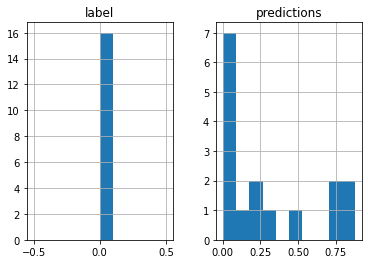

In [27]:
control.hist()

In [28]:
print(df_selected)

                    name                  label     patient  signal_length
0    patient001/s0010_re  Myocardial infarction  patient001          38400
1    patient001/s0014lre  Myocardial infarction  patient001         115200
2    patient001/s0016lre  Myocardial infarction  patient001         115200
3    patient002/s0015lre  Myocardial infarction  patient002         115200
4    patient003/s0017lre  Myocardial infarction  patient003         115200
..                   ...                    ...         ...            ...
544  patient292/s0555_re  Myocardial infarction  patient292         120012
545  patient292/s0556_re  Myocardial infarction  patient292         120012
546  patient293/s0557_re  Myocardial infarction  patient293         120012
547  patient293/s0558_re  Myocardial infarction  patient293         120012
548  patient294/s0559_re  Myocardial infarction  patient294         120012

[368 rows x 4 columns]


In [29]:
record.label = comments_to_dict(record.comments)['Reason for admission']

In [30]:
record.label

' Myocardial infarction'

In [31]:
comments_to_dict(record.comments)

{'age': ' 61',
 'sex': ' female',
 'ECG date': ' 05/06/1997',
 'Diagnose': '',
 'Reason for admission': ' Myocardial infarction',
 'Acute infarction (localization)': ' inferior',
 'Former infarction (localization)': ' no',
 'Additional diagnoses': ' unknown',
 'Smoker': ' unknown',
 'Number of coronary vessels involved': ' unknown',
 'Infarction date (acute)': ' 24-May-97',
 'Previous infarction (1) date': ' n/a',
 'Previous infarction (2) date': ' n/a',
 'Hemodynamics': '',
 'Catheterization date': ' n/a',
 'Ventriculography': ' n/a',
 'Chest X-ray': ' n/a',
 'Peripheral blood Pressure (syst/diast)': ' n/a',
 'Pulmonary artery pressure (at rest) (syst/diast)': ' n/a',
 'Pulmonary artery pressure (at rest) (mean)': ' n/a',
 'Pulmonary capillary wedge pressure (at rest)': ' n/a',
 'Cardiac output (at rest)': ' n/a',
 'Cardiac index (at rest)': ' n/a',
 'Stroke volume index (at rest)': ' n/a',
 'Pulmonary artery pressure (laod) (syst/diast)': ' n/a',
 'Pulmonary artery pressure (laod) (m

In [115]:
    io.dl_database(db, 'data', [record['name'] for record in records])

Generating record list for: patient001/s0010_re
Generating record list for: patient001/s0014lre
Generating record list for: patient001/s0016lre
Generating record list for: patient002/s0015lre
Generating record list for: patient003/s0017lre
Generating record list for: patient004/s0020are
Generating record list for: patient004/s0020bre
Generating record list for: patient005/s0021are
Generating record list for: patient005/s0021bre
Generating record list for: patient005/s0025lre
Generating record list for: patient005/s0031lre
Generating record list for: patient005/s0101lre
Generating record list for: patient006/s0022lre
Generating record list for: patient006/s0027lre
Generating record list for: patient006/s0064lre
Generating record list for: patient007/s0026lre
Generating record list for: patient007/s0029lre
Generating record list for: patient007/s0038lre
Generating record list for: patient007/s0078lre
Generating record list for: patient008/s0028lre
Generating record list for: patient008/s